In [9]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
import tensorflow as tf

## Defining Functions

We fit a nonlinear model $y = f(x;\beta) + \epsilon$ to a given dataset below, where $f(x;\beta) = \beta_0\cdot\exp(x/\beta_1)$.

In [10]:
def model(x, truth_beta):
    return truth_beta[0]*np.exp(x/truth_beta[1])


def Fval(x, y, beta):
    return model(x, beta) - y


def Jac(x, beta):
    return np.array([np.exp(x/beta[1]), -(beta[0]/beta[1]**2)*np.exp(x/beta[1])*x])

## Generate datasets

In [35]:
beta_truth = [0.15, 3.75]
x_train = np.linspace(0, 10, num=50)
y_train = model(x_train, beta_truth) + np.random.normal(0, 0.1, size=len(x_train))

## Default Gauss-Newton Method

Iteration:  0 -- Error: 2.9097e+05
Iteration:  1 -- Error: 5.6365e+03
Iteration:  2 -- Error: 1.0658e+03
Iteration:  3 -- Error: 1.7647e+02
Iteration:  4 -- Error: 2.9489e+01
Iteration:  5 -- Error: 3.4689e+00
Iteration:  6 -- Error: 8.4540e-02
Iteration:  7 -- Error: 1.0439e-04
>>> Convergence achieved!

Parameters: [0.16245592 3.83368508] 
Error:  0.0001043908923433161 
Number of Iterations:  7


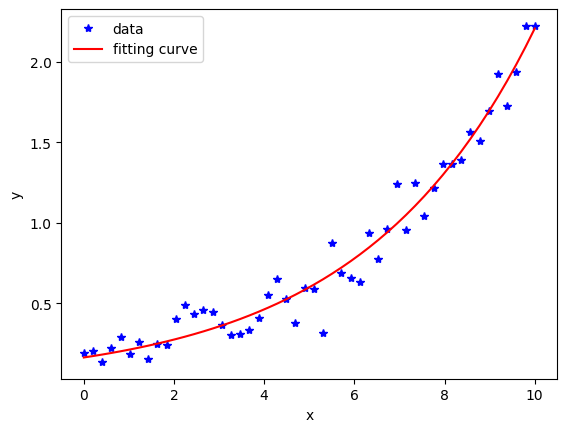

In [36]:
# Default Gauss-Newton Method
def GN(Fx, Jac, x, y, beta0, maxiter = 100, tol = 1e-3):
    bet = beta0
    err  = 0
    for t in range(0, maxiter):
        Ft  = Fx(x, y, bet)
        Jt  = Jac(x, bet)
        St  = la.pinv(Jt.dot(Jt.T))
        yt  = Jt.dot(Ft).T
        dt  = np.ravel(St.dot(yt))
        bet = bet - dt
        err = la.norm(yt)
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
    return bet, err, t

# We run it.
beta0 = [1, 2]
beta_best, err, n_it = GN(Fval, Jac, x_train, y_train, beta0, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ", err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## AutoDiff Gauss-Newton Method

Iteration:  0 -- Error: 2.9097e+05
Iteration:  1 -- Error: 5.6365e+03
Iteration:  2 -- Error: 1.0658e+03
Iteration:  3 -- Error: 1.7647e+02
Iteration:  4 -- Error: 2.9489e+01
Iteration:  5 -- Error: 3.4689e+00
Iteration:  6 -- Error: 8.4540e-02
Iteration:  7 -- Error: 1.0439e-04
>>> Convergence achieved!

Parameters: [0.16245592 3.83368508] 
Error:  0.00010439089241475059 
Number of Iterations:  7


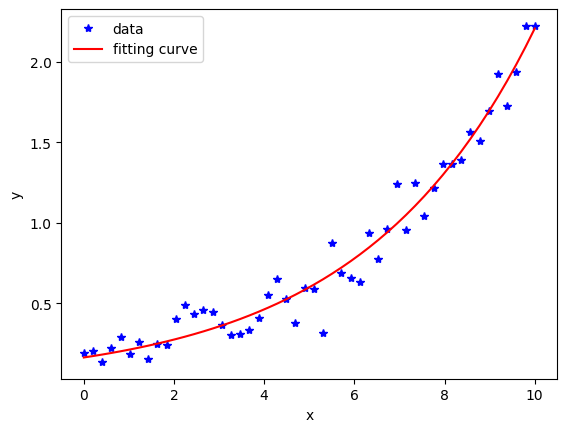

In [37]:
def tf_model(x, truth_beta):
    return tf.multiply(truth_beta[0], tf.exp(tf.divide(x, truth_beta[1])))

# Default Gauss-Newton Method
def GN_Auto_Diff(Fx, tf_Fx, x, y, beta0, maxiter=100, tol=1e-3):
    bet = beta0
    err = 0
    for t in range(0, maxiter):
        Ft = Fx(x, y, bet)

        # Compute value of Jacobian matrix using Auto Diff
        tf_x = tf.constant(x, dtype=tf.float64)
        tf_bet = tf.Variable(bet, dtype=tf.float64)
        with tf.GradientTape() as tape:
            J = tf_Fx(tf_x, tf_bet)
        Jt = tape.jacobian(J, tf_bet).numpy().T
        
        St = la.pinv(Jt.dot(Jt.T))
        yt = Jt.dot(Ft).T
        dt = np.ravel(St.dot(yt))
        bet = bet - dt
        err = la.norm(yt)
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
    return bet, err, t


# Running
beta0 = [1, 2]
beta_best, err, n_it = GN_Auto_Diff(Fval, tf_model, x_train, y_train, beta0, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ", err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Damped Gauss-Newton Method

Iteration:  0 -- Error: 2.9097e+05
Iteration:  1 -- Error: 2.4007e+05
Iteration:  2 -- Error: 1.9868e+05
Iteration:  3 -- Error: 1.6497e+05
Iteration:  4 -- Error: 1.3748e+05
Iteration:  5 -- Error: 1.1502e+05
Iteration:  6 -- Error: 9.6610e+04
Iteration:  7 -- Error: 8.1485e+04
Iteration:  8 -- Error: 6.9012e+04
Iteration:  9 -- Error: 5.8684e+04
Iteration: 10 -- Error: 5.0093e+04
Iteration: 11 -- Error: 4.2912e+04
Iteration: 12 -- Error: 3.6878e+04
Iteration: 13 -- Error: 3.1781e+04
Iteration: 14 -- Error: 2.7453e+04
Iteration: 15 -- Error: 2.3760e+04
Iteration: 16 -- Error: 2.0593e+04
Iteration: 17 -- Error: 1.7865e+04
Iteration: 18 -- Error: 1.5508e+04
Iteration: 19 -- Error: 1.3464e+04
Iteration: 20 -- Error: 1.1688e+04
Iteration: 21 -- Error: 1.0140e+04
Iteration: 22 -- Error: 8.7912e+03
Iteration: 23 -- Error: 7.6140e+03
Iteration: 24 -- Error: 6.5867e+03
Iteration: 25 -- Error: 5.6905e+03
Iteration: 26 -- Error: 4.9093e+03
Iteration: 27 -- Error: 4.2292e+03
Iteration: 28 -- Err

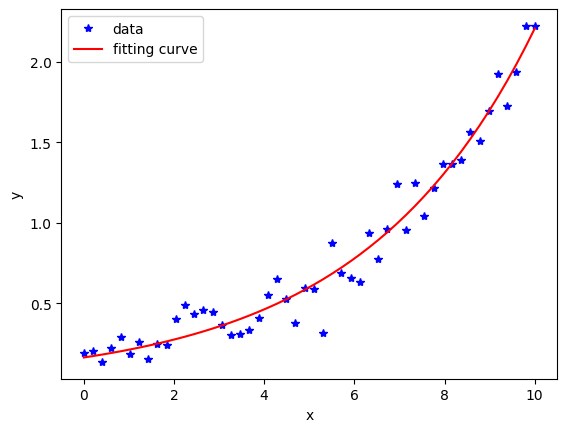

In [38]:
# Damped Gauss-Newton Method
def GN_damped(Fx, Jac, x, y, beta0, stepsize=1, maxiter=100, tol=1e-3):
    bet = beta0
    err = 0
    t = 0
    while t < maxiter:
        Ft = Fx(x, y, bet)
        Jt = Jac(x, bet)
        St = la.pinv(Jt.dot(Jt.T))
        yt = Jt.dot(Ft).T
        dt = np.ravel(St.dot(yt))
        err = la.norm(yt)

        # Add step size
        bet = bet - stepsize * dt
        
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
        t += 1
    return bet, err, t


# We run it.
beta0 = [1, 2]
beta_best, err, n_it = GN_damped(
    Fval, Jac, x_train, y_train, beta0=beta0, stepsize=0.1, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ",
      err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Line Search

### Naive Approach

- A bit more flexible than the default implementation in terms of choosing initial point
- However, when the initial point is too far away from the truth point, this approach still fails

Iteration:  0 -- Error: 1.1497e+03
Line Search
Line Search
Line Search
Iteration:  1 -- Error: 8.0929e+01
Iteration:  2 -- Error: 6.0636e+02
Iteration:  3 -- Error: 9.6103e+01
Iteration:  4 -- Error: 1.5397e+01
Iteration:  5 -- Error: 1.2871e+00
Iteration:  6 -- Error: 1.3359e-02
Iteration:  7 -- Error: 1.2543e-05
>>> Convergence achieved!

Parameters: [0.16245601 3.83368606] 
Error:  1.2542947751801238e-05 
Number of Iterations:  7


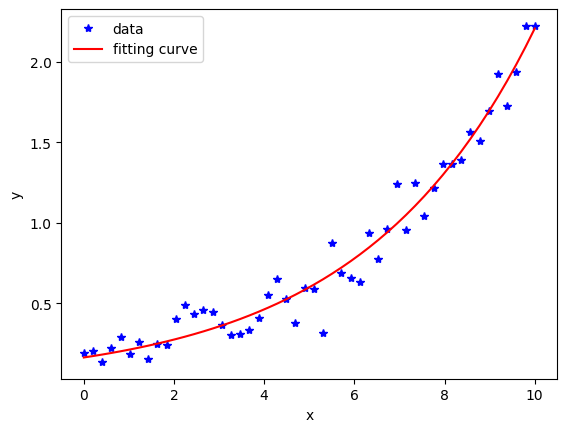

In [39]:
# Damped Gauss-Newton Method
def GN_naive_linesearch(Fx, Jac, x, y, beta0, stepsize=1, maxiter=100, tol=1e-3):
    beta = beta0
    err = 0
    t = 0
    while t < maxiter:
        Ft = Fx(x, y, beta)
        Jt = Jac(x, beta)
        St = la.pinv(Jt.dot(Jt.T))
        yt = Jt.dot(Ft).T
        dt = np.ravel(St.dot(yt))
        err = la.norm(yt)

        # Naive Line Search
        current_stepsize = stepsize
        while True:
            next_bet = beta - current_stepsize * dt
            next_Ft = Fx(x, y, next_bet)
            if la.norm(next_Ft) <= la.norm(Ft):
                break
            print("Line Search")
            current_stepsize /= 2

        beta = next_bet
        print("Iteration: {0:2d}".format(t), "-- Error: {0:5.4e}".format(err))
        if err <= tol:
            print(">>> Convergence achieved!")
            break
        t += 1
    return beta, err, t


# We run it.
beta0 = [6, 9]
beta_best, err, n_it = GN_naive_linesearch(
    Fval, Jac, x_train, y_train, beta0=beta0, maxiter=1000)
print("\nParameters:", beta_best, "\nError: ",
      err, "\nNumber of Iterations: ", n_it)

# Plotting
plt.plot(x_train, y_train, 'b*', label='data')
plt.plot(x_train, model(x_train, beta_best), "-r", label="fitting curve")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Armijo Condition

### Wolfe Condition